# Test using CIFAR-10 with small datasets

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Load Modules
sys.path.append('/content/drive/MyDrive/Modules')

Mounted at /content/drive


Using CUDA
Files already downloaded and verified
Files already downloaded and verified
Using LBFGS!
--- 0.1407935619354248 seconds ---
[1,     1] loss: 0.001
[1,     2] loss: 0.001
[1,     3] loss: 0.001
[1,     4] loss: 0.002
[1,     5] loss: 0.001
[1,     6] loss: 0.001
[1,     7] loss: 0.001
[1,     8] loss: 0.001
[1,     9] loss: 0.001
[1,    10] loss: 0.001
[1,    11] loss: 0.001
[1,    12] loss: 0.001
[1,    13] loss: 0.001
[1,    14] loss: 0.001
[1,    15] loss: 0.001
[1,    16] loss: 0.001
[1,    17] loss: 0.001
[1,    18] loss: 0.001
[1,    19] loss: 0.001
[1,    20] loss: 0.001
[1,    21] loss: 0.001
[1,    22] loss: 0.001
[1,    23] loss: 0.001
[1,    24] loss: 0.001
[1,    25] loss: 0.001
[1,    26] loss: 0.001
[1,    27] loss: 0.001
[1,    28] loss: 0.001
[1,    29] loss: 0.001
[1,    30] loss: 0.001
[1,    31] loss: 0.001
[1,    32] loss: 0.001
[1,    33] loss: 0.001
[1,    34] loss: 0.001
[1,    35] loss: 0.001
[1,    36] loss: 0.001
[1,    37] loss: 0.001
[1,    38] los

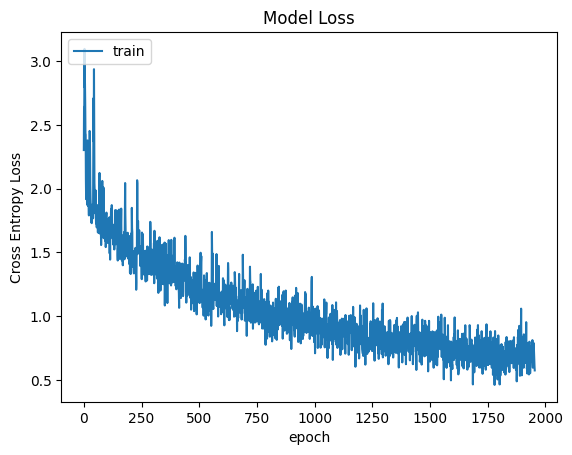

ValueError: ignored

In [5]:
import torch 
import torchvision
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable
from lbfgs_modify import LBFGSModify
import torch.nn.functional as F
import numpy as np
import time
import utils

batch_size = 128
epoch = 5
correct=0
total=0
lambda1=0.000001
lambda2=0.001
use_cuda=True
if use_cuda and torch.cuda.is_available():
  mydevice=torch.device('cuda')
  print ('Using CUDA')
else:
  mydevice=torch.device('cpu')
  print ('Using CPUs')

### Data Loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)
#####################################################
def verification_error_check(net):
   correct=0
   total=0
   for data in testloader:
     test_images,test_labels=data
     outputs=net(Variable(test_images).to(mydevice))
     _,predicted=torch.max(outputs.data,1)
     correct += (predicted==test_labels.to(mydevice)).sum()
     total += test_labels.size(0)

   return 100*correct//total
#####################################################
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.elu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.elu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.linear1 = nn.Linear(32*32, 512) 
        self.linear2 = nn.Linear(512, 512) 
        self.final = nn.Linear(512, 4)
        self.Relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 32*32)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.elu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet9():
    return ResNet(BasicBlock, [1,1,1,1], num_classes)
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2], num_classes)
def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def closure():
        if torch.is_grad_enabled():
         optimizer.zero_grad()
         #print("Using zero gradient")
        outputs=net(inputs)
        l1_penalty=lambda1*(torch.norm(layer1,1)+torch.norm(layer2,1)+torch.norm(layer3,1)+torch.norm(layer4,1))
        l2_penalty=lambda2*(torch.norm(layer1,2)+torch.norm(layer2,2)+torch.norm(layer3,2)+torch.norm(layer4,2))
        loss=cross_entropy(outputs,labels)+l1_penalty+l2_penalty   # Cross entropy loss with softmax
        #Its using this: print("Apply penalty in Loss function")

        if loss.requires_grad:
          loss.backward()
         #Its using this: print('Backward Loss: %f l1 %f l2 %f'%(loss,l1_penalty,l2_penalty))
        return loss   
start_time = time.time()
   
if __name__ == '__main__':
    net=ResNet9().to(mydevice)
    cross_entropy = nn.CrossEntropyLoss()  # This combines with softmax
   # optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #e-1
    optimizer=LBFGSModify(net.parameters(), history_size=7, max_iter=2, line_search_fn=True,batch_mode=True)
     
    # get some random training images
    # dataiter = iter(trainloader)
    # images, labels = next(dataiter)
    
    # show images
    # imshow(torchvision.utils.make_grid(images))
    # print labels
    #print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    
    use_lbfgs=True
    if not use_lbfgs:
        # Use for Adam
        print("Not using LBFGS!")
    else:
        print("Using LBFGS!")
        
    adam_loss = []
    cnn_loss = []
    # Check cuda availability
    cuda = torch.cuda.is_available()
    # Create neural network model
    if cuda:
        torch.cuda.manual_seed(2018)
        model = CNN().cuda() 
    else:
        torch.manual_seed(2018)
        model = CNN()
        cuda = torch.cuda.is_available()
    if cuda:
        opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
    else:
        opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
    if cuda:
        predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
    else:
        predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
    accfun = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze())) * 100
    
    for epoch in range(epoch):
        net.train()
        running_loss = 0.0
        print("--- %s seconds ---" % (time.time() - start_time))
        i=0
       # while i<10:
        for i, data in enumerate(trainloader, 0):  # Reset the training iterator for each epoch
            # if i > 10:
            #     break
            inputs, labels = data
            # wrap them in variable
            inputs,labels=Variable(inputs).to(mydevice),Variable(labels).to(mydevice)
            
            if not use_lbfgs:
                # Use for Adam
                # zero gradients
                optimizer.zero_grad()
                # forward+backward optimize
                outputs=net(inputs)
                loss=cross_entropy(outputs,labels)
                loss.backward()
                adam_loss.append(loss.item())
                optimizer.step()
            else:
            
            # Use for LBFGS
                layer1=torch.cat([x.view(-1) for x in net.layer1.parameters()])
                layer2=torch.cat([x.view(-1) for x in net.layer2.parameters()])
                layer3=torch.cat([x.view(-1) for x in net.layer3.parameters()])
                layer4=torch.cat([x.view(-1) for x in net.layer4.parameters()])    
                outputs=net(inputs)
                optimizer.step(closure)
                test_loss=cross_entropy(outputs,labels)
                    
                # print running statistics
                running_loss += test_loss.item()
                
                cnn_loss.append(test_loss.item())
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                i = i+1
    
    print("--- %s seconds ---" % (time.time() - start_time))
#### Analysis Code ####
# whole dataset
    correct=0
    total=0
    for data in trainloader:
       train_images,train_labels=data
       outputs=net(Variable(train_images).to(mydevice)).cpu()
       _,predicted=torch.max(outputs.data,1)
       total += train_labels.size(0)
       correct += (predicted==train_labels).sum()
       
    print('Accuracy of the network on the %d training images: %d %%'%(total,torch.div(100*correct, total, rounding_mode='trunc')))
       
    correct=0
    total=0
    for data in testloader:
       test_images,test_labels=data
       outputs=net(Variable(test_images).to(mydevice)).cpu()
       _,predicted=torch.max(outputs.data,1) # Predicted labels
       total += test_labels.size(0)  # Number of labels in tensor
       correct += (predicted==test_labels).sum()
       
    print('Accuracy of the network on the %d test images: %d %%'%(total,torch.div(100*correct, total, rounding_mode='trunc')))
    
    class_correct=list(0. for i in range(num_classes))
    class_total=list(0. for i in range(num_classes))
    
    for data in testloader:
      test_images,test_labels=data
      outputs=net(Variable(test_images).to(mydevice)).cpu()
      _,predicted=torch.max(outputs.data,1)
      c=(predicted==test_labels).squeeze()
      for i in range(4):
        label=test_labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
    for i in range(num_classes):
      if (class_total[i]==0):
          print('Class is 0.0: ',classes[i])
      else:
        print('Accuracy of %5s : %2d %%' %
        (classes[i],100*float(class_correct[i])/float(class_total[i])))
        
   ##### Plots ##### 
    plt.plot(cnn_loss)
    plt.title('Model Loss')
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # compute statistics
    model.eval()
    train_loss, test_loss, test_acc = utils.compute_stats(train_images, train_labels, test_images, test_labels, opfun, accfun,ghost_batch=128)

